In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


def init_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    return (tokenizer, config, model)

In [2]:
import pandas as pd

file_path = "data/1comments.h5"
df = pd.read_hdf(file_path, key='df')
df.sample(3)

,id,createdAt,userId,userCreatedAt,classYear,universityId,country,universityName,parentId,questionId,comment,review,chapter_explanation_update,question_update,question_explanation_update,qc_explanation_update
3416,5202,2021-11-11 16:49:33.957000+00:00,9385,2021-05-30 08:35:38.831000+00:00,Year 4,2670,United Kingdom,University of Southampton,1145.0,2074,Haemophilus influenzae is a cause of acute epi...,False,None,None,None,None
14930,19521,2023-03-06 14:41:29.359434+00:00,13211,2021-10-19 06:15:15.537000+00:00,Year 5,2657,United Kingdom,University of Manchester,NaN,1436,weird q but easily answerable if you take your...,False,None,None,None,None
15896,20596,2023-03-22 13:15:26.672329+00:00,27328,2022-11-22 22:43:53.825878+00:00,Year 4,2639,United Kingdom,University of Edinburgh,NaN,8377,'Drowsy' is a bit of a loose term,False,None,None,None,None


In [3]:
from datasets import Dataset

def dataloader(ds: Dataset):
  for item in ds:
    yield item['text']

ds = Dataset.from_dict({'text': df['comment']})

# Tone analysis

Checking the tone of submissions

In [4]:
tone_ckpt = "fine-tuning-final/tone"

In [5]:
tone_tokenizer, tone_config, tone_model = init_model(tone_ckpt)


In [6]:
from transformers import pipeline
from tqdm import tqdm

tone_pipe = pipeline("sentiment-analysis", 
  model=tone_model, 
  device=device,
  tokenizer=tone_tokenizer,
  max_length=512, 
  truncation=True
)

tone_labels = ['neutral', 'negative', 'positive']

tone_pipe('Cases of Covid are rising!', top_k=len(tone_labels), batch_size=64)

[{'label': 'neutral', 'score': 0.5718153119087219},
 {'label': 'negative', 'score': 0.40707287192344666},
 {'label': 'positive', 'score': 0.02111182175576687}]

In [7]:
res_emotion = []
for res in tqdm(tone_pipe(dataloader(ds), top_k=len(tone_labels), batch_size=64), total=ds.num_rows):
  res_sorted = sorted(res, key=lambda x: x['label'])
  res_emotion.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_emotion, columns=tone_labels))

100%|██████████| 24912/24912 [02:47<00:00, 148.88it/s]


In [8]:
df['tone'] = df[tone_labels].idxmax(axis=1)

In [10]:
df.to_hdf('data/tuned/2comments.h5', key='df', mode='w')
# df = pd.read_hdf('data/tuned/2comments.h5', key='df')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_89440/182183184.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone'],
      dtype='object')]

  df.to_hdf('data/tuned/2comments.h5', key='df', mode='w')


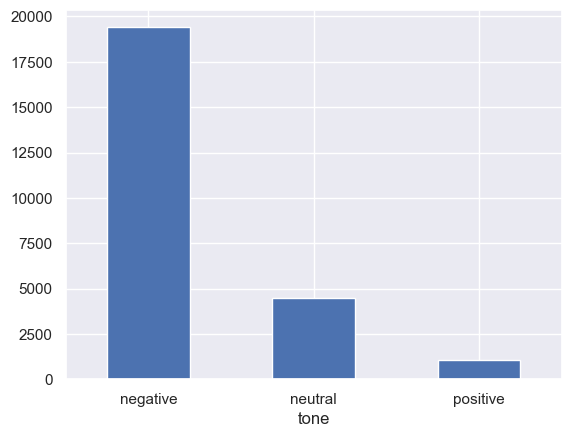

In [11]:
fig, ax = plt.subplots()
ax = df['tone'].value_counts().plot(kind='bar')
plt.xticks(rotation=0, ha='center')
plt.show()

# Emotion Analysis

Checking the emotion of submissions

In [12]:
emotion_chkp = "fine-tuning-final/emotion"
emotion_tokenizer, emotion_config, emotion_model = init_model(emotion_chkp)


In [13]:
emotion_pipe = pipeline("zero-shot-classification", 
  model=emotion_model,
  tokenizer=emotion_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

emotion_pipe('Cases of Covid are rising!', 
             top_k=len(emotion_labels), 
             candidate_labels=emotion_labels
             )

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'sequence': 'Cases of Covid are rising!',
 'labels': ['surprise', 'joy', 'love', 'sadness', 'anger', 'fear'],
 'scores': [0.2170352190732956,
  0.17403945326805115,
  0.1592649221420288,
  0.15278464555740356,
  0.15202359855175018,
  0.1448521465063095]}

In [14]:
res_emotion = []
for res in tqdm(emotion_pipe(dataloader(ds), top_k=len(emotion_labels), batch_size=64, candidate_labels=emotion_labels), total=ds.num_rows):
  res_list = []
  for label, score in zip(res['labels'], res['scores']):
    res_list.append({'label': label, 'score': score})
  res_sorted = sorted(res_list, key=lambda x: x['label'])
  res_emotion.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_emotion, columns=emotion_labels))

100%|██████████| 24912/24912 [05:04<00:00, 81.84it/s] 


In [15]:
df['emotion'] = df[emotion_labels].idxmax(axis=1)

In [16]:
df.to_hdf('data/tuned/3comments.h5', key='df', mode='w')
# df = pd.read_hdf('data/tuned/3comments.h5', key='df')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_89440/215985439.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone',
       'emotion'],
      dtype='object')]

  df.to_hdf('data/tuned/3comments.h5', key='df', mode='w')


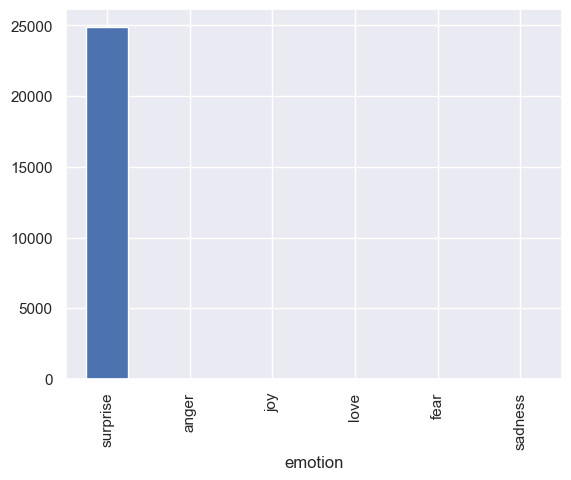

In [17]:
fig, ax = plt.subplots()
ax = df['emotion'].value_counts().plot(kind='bar')

plt.show()

In [18]:
df.head()

,id,createdAt,userId,userCreatedAt,classYear,universityId,country,universityName,parentId,questionId,...,negative,positive,tone,sadness,joy,love,anger,fear,surprise,emotion
0,2,2021-03-25 11:22:56.133000+00:00,1195,2019-03-18 18:41:10.891000+00:00,Year 4,2620,United Kingdom,University College London (UCL),NaN,1170,...,0.143679,0.800420,positive,0.160237,0.149210,0.170455,0.148032,0.154789,0.217277,surprise
1,4,2021-03-25 12:14:48.834000+00:00,1542,2019-06-01 20:00:49.151000+00:00,Year 5,2620,United Kingdom,University College London (UCL),NaN,1090,...,0.808160,0.015522,negative,0.155475,0.154379,0.159927,0.155009,0.159747,0.215463,surprise
2,5,2021-03-25 12:17:29.904000+00:00,1542,2019-06-01 20:00:49.151000+00:00,Year 5,2620,United Kingdom,University College London (UCL),NaN,2603,...,0.906133,0.015373,negative,0.147198,0.149922,0.168501,0.160598,0.158575,0.215206,surprise
3,6,2021-03-25 12:17:57.305000+00:00,1542,2019-06-01 20:00:49.151000+00:00,Year 5,2620,United Kingdom,University College London (UCL),NaN,2603,...,0.864062,0.020754,negative,0.154161,0.154189,0.169797,0.157774,0.154584,0.209495,surprise
4,7,2021-03-25 12:24:38.100000+00:00,5153,2021-03-13 09:38:17.793000+00:00,Year 5,9364,United Kingdom,Barts and The London School of Medicine and De...,NaN,1480,...,0.852484,0.017841,negative,0.158350,0.155749,0.172158,0.153890,0.157563,0.202291,surprise


# Zero-shot classification

Classification of submissions based on certain categories

In [64]:
from transformers import AutoModelForSequenceClassification

theme_chkp = "facebook/bart-large-mnli"
theme_tokenizer, _, _ = init_model(theme_chkp)

theme_labels = ['educational', 'giving feedback', 'asking a question', 'insulting', 'supporting']

id2label = {i: k for i, k in enumerate(theme_labels)}
label2id = {k: i for i, k in enumerate(theme_labels)}

theme_model = AutoModelForSequenceClassification.from_pretrained(theme_chkp,
  num_labels=len(theme_labels),
  id2label=id2label,
  label2id=label2id,
  ignore_mismatched_sizes=True
)

theme_pipe = pipeline("zero-shot-classification", 
  model=theme_model,
  tokenizer=theme_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

def theme_analysis(text: str, multi_label=False):
  res = theme_pipe(text, theme_labels, multi_label=multi_label)

  output = {k: 0.0 for k in theme_labels}

  for k, score in zip(res['labels'], res['scores']):
      output[k] = score
  
  return output

theme_analysis("Covid cases are increasing fast!")

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'educational': 0.2142215371131897,
 'giving feedback': 0.1849270462989807,
 'asking a question': 0.27699366211891174,
 'insulting': 0.16431444883346558,
 'supporting': 0.15954318642616272}

In [40]:
for k in theme_labels:
    df[k] = 0.0

In [41]:
for id in tqdm(df.index):
    selftext = df.at[id, 'comment']
    if len(selftext) == 0:
        continue
    output = theme_analysis(selftext)
    for k in theme_labels:
        df.at[id, k] = output[k]

100%|██████████| 22514/22514 [5:54:48<00:00,  1.06it/s]    


In [42]:
df['theme'] = df[theme_labels].idxmax(axis=1)

In [65]:
df.to_hdf('data/4comments.h5', key='df', mode='w')
# df = pd.read_hdf('data/4comments.h5', key='df')

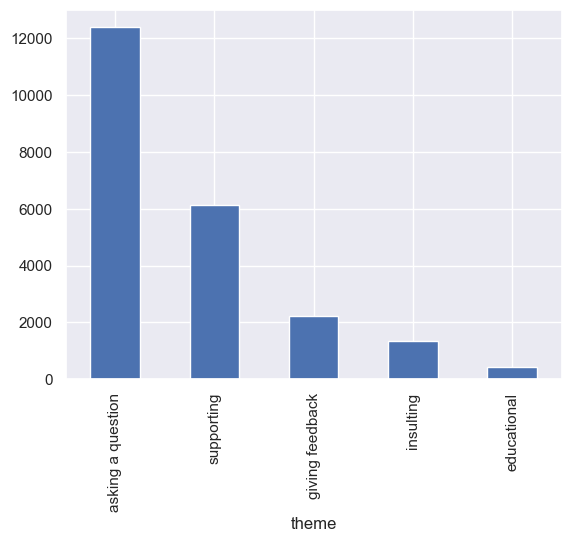

In [66]:
fig, ax = plt.subplots()
ax = df['theme'].value_counts().plot(kind='bar')

plt.show()